In [1]:
%load_ext autoreload
%matplotlib inline

In [129]:
%autoreload 2

import sys,os,glob
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import warnings

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
moduledir = os.path.join(os.path.dirname(workdir),'src')
functionsdir = os.path.join(os.path.dirname(workdir),'plotting/src')
sys.path.insert(0,moduledir)
sys.path.insert(0,functionsdir)
for includedir in [moduledir,functionsdir]:
    print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                     for x in glob.glob(os.path.join(includedir,'*.py'))])

from conditionalstats import *
from plot1DInvLog import *
from plot2D import *

## Input data dir
inputdir = os.path.join(os.path.dirname(workdir),'input')

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

Own modules available: ['conditionalstats']
Own modules available: ['plot2D', 'plotCondPDFs', 'plot1DInvLog']


In [4]:
print("import some 2D variables")
# file2D = os.path.join(inputdir,'fplane_n01_300_i03_256.2Dcom_1.nc')
file2D = os.path.join(inputdir,'data2D.nc')
varids2drop = ['SHF', 'LHF', 'LWNS', 'LWNSC', 'LWNT', 'LWNTC', 'SWNS', 'SWNSC', 'SWNT', 'SWNTC', 'IntQN', 'IntQP', 'MSE', 'USFC', 'VSFC', 'W500', 'SWVP', 'TSFC', 'QSFC']
ds_2D = xr.open_dataset(file2D,decode_cf=False,drop_variables=varids2drop)

import some 2D variables


In [5]:
print("import some 3D variables")
# file3D = os.path.join(inputdir,'fplane_n01_300_i03_256_0000864000.com3D.alltimes.nc')
file3D = os.path.join(inputdir,'data3D.nc')
varids2drop = ['p', 'U', 'V', 'TABS']
ds_3D = xr.open_dataset(file3D,decode_cf=False,drop_variables=varids2drop)

import some 3D variables


In [7]:
print("pick reference time")
# dt_2D = np.diff(ds_2D.time)[0] # days
# t_0 = 20 # days
# i_t2D = int(t_0/dt_2D)
# dt_3D = np.diff(ds_3D.time)[0] # days
# i_t3D = int(t_0/dt_3D)
i_t2D = i_t3D = 0

pick reference time


## Compute conditional mean and variance : conditional scalar

In [8]:
print("compute distribution of reference variable")
ref_varid = 'PW'
verbose = False
# Initialize
ref_dist_linear = Distribution(name=ref_varid)
# Compute
ref_dist_linear.computeDistribution(sample=ds_2D[ref_varid][i_t2D].values)
# Compute locations of reference bins
ref_dist_linear.storeSamplePoints(sample=ds_2D[ref_varid][i_t2D].values,verbose=verbose)

compute distribution of reference variable


In [9]:
print('check size')
ref_dist_linear.nlb, ref_dist_linear.nbins

check size


(50, 50)

In [10]:
print("compute conditional distribution for a 2D variable")
verbose = True
cond_varid_2D = 'Prec'
# Initialize
cond_dist_2D = ConditionalDistribution(name=cond_varid_2D,
                                       is3D=False,
                                       on=ref_dist_linear)
# Compute conditional distributions
cond_dist_2D.computeConditionalMeanAndVariance(sample=ds_2D[cond_varid_2D][i_t2D].values,
                                               verbose=False)


compute conditional distribution for a 2D variable


showing conditional distribution of 2D variable


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':


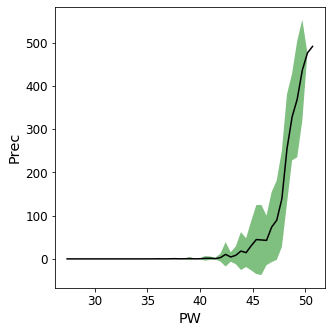


# INCLUDE SUBPLOT FUNCTION INSIDE CONDITIONALDISTRIBUTION OBJECT
# ADD attributes self.cond_std, self.cond_Q1, self.cond_med, self.cond_Q3 for interquartile range



In [11]:
print("showing conditional distribution of 2D variable")
fig,ax = plt.subplots(figsize=(5,5))
# plot mean
ax.plot(cond_dist_2D.on.percentiles,cond_dist_2D.cond_mean,'k')
# plot 1-sigma standard error
x = cond_dist_2D.on.percentiles
y1 = cond_dist_2D.cond_mean - np.sqrt(cond_dist_2D.cond_var)
y2 = cond_dist_2D.cond_mean + np.sqrt(cond_dist_2D.cond_var)
ax.fill_between(x,y1,y2,where=y2>=y1,facecolor='g',alpha=0.5,interpolate=True)

ax.set_xlabel(ref_varid)
ax.set_ylabel(cond_varid_2D)

plt.show()
print("""
# INCLUDE SUBPLOT FUNCTION INSIDE CONDITIONALDISTRIBUTION OBJECT
# ADD attributes self.cond_std, self.cond_Q1, self.cond_med, self.cond_Q3 for interquartile range
""")

## Compute conditional mean and variance : conditional profiles

In [138]:
print("compute conditional distribution for a 3D variable")
cond_varid_3D = 'QRAD'
# Initialize
cond_dist_3D = ConditionalDistribution(name=cond_varid_3D,
                                       is3D=True,
                                       on=ref_dist_linear)
# Compute conditional distributions
cond_dist_3D.computeConditionalMeanAndVariance(ds_3D[cond_varid_3D][i_t3D].values)


compute conditional distribution for a 3D variable


showing conditional distribution of 2D variable


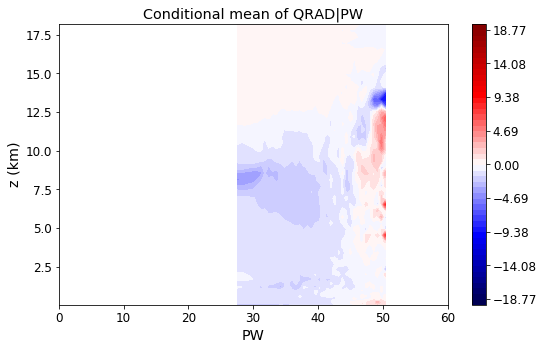

In [139]:
print("showing conditional distribution of 2D variable")

## Plot parameters
x = cond_dist_3D.on.percentiles
y = ds_3D.z/1000
Z = cond_dist_3D.cond_mean
vmax = max(np.abs(np.nanmax(Z)),np.abs(np.nanmin(Z)))
vmin = -vmax

## Plot
fig,ax = plt.subplots(figsize=(9,5))
h = subplotSmooth2D(ax,x,\
                  y,\
                  Z,\
               fplot='contourf',\
               xmin=0,xmax=60,nx=100,\
               vmin=vmin,vmax=vmax,\
               cmap = plt.cm.seismic)
ax.set_xlabel(ref_varid)
ax.set_ylabel('z (km)')
ax.set_title('Conditional mean of %s|%s'%(cond_varid_3D,ref_varid))

plt.colorbar(h)

plt.show()

showing conditional distribution of 2D variable


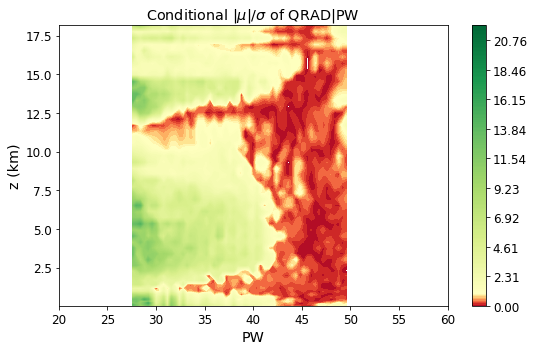

In [140]:
print("showing conditional distribution of 2D variable")

## Plot parameters
x = cond_dist_3D.on.percentiles
y = ds_3D.z/1000
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    Z = np.absolute(cond_dist_3D.cond_mean)/cond_dist_3D.cond_std
vmax = max(np.abs(np.nanmax(Z[np.isfinite(Z)])),np.abs(np.nanmin(Z[np.isfinite(Z)])))
vmin = 0

norm = MidpointNormalize(midpoint=1,vmin=vmin,vmax=vmax)

## Plot
fig,ax = plt.subplots(figsize=(9,5))
h = subplotSmooth2D(ax,x,\
                  y,\
                  Z,\
               fplot='contourf',\
               xmin=20,xmax=60,nx=100,\
               vmin=vmin,vmax=vmax,nlev=200,\
               cmap = plt.cm.RdYlGn,\
               norm=norm)
ax.set_xlabel(ref_varid)
ax.set_ylabel('z (km)')
ax.set_title('Conditional $|\mu|/\sigma$ of %s|%s'%(cond_varid_3D,ref_varid))

plt.colorbar(h)

plt.show()

In green where signal-to-noise is greater than 1, in red where it is below 1